<a href="https://colab.research.google.com/github/dekovski/GLA_Neural_Lyapunov/blob/main/Example2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Example 2: 10d Multi-agent system](https://colab.research.google.com/drive/1_asH22FD43Nr_fEbHKKSw_EYJ4zfzzCf#scrollTo=oOYRzVG2aIBv&line=1&uniqifier=1)**

In [ ]:
%%capture
!pip install networkx
!pip install torchdiffeq
!pip install nangs

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from torchdiffeq import odeint
import nangs
import math


device = "cuda" if torch.cuda.is_available() else "cpu"
nangs.__version__, torch.__version__

np.random.seed(10)
torch.manual_seed(0)

n = 10 # number of agents
#G = nx.gnc_graph(n)
G = nx.connected_watts_strogatz_graph(n,4,0.2)
Adj = np.zeros((n,n))
idx = list(G.edges())
for i in idx:
  Adj[i]=1
Adj = sp.Matrix(Adj + Adj.T)
x = sp.symbols('x1:'+str(n+1), real=True)

a = sp.matrices.dense.matrix_multiply_elementwise(Adj,sp.Matrix([[np.random.rand()*(1.2*sp.tanh(xa-xb) +
                                                                  sp.sin(xa-xb)) for xa in x] for xb in x]))*sp.ones(n,1)
b = sp.Matrix([1/(1+sp.exp(-x_)) for x_ in x])
f = sp.matrices.dense.matrix_multiply_elementwise(b,a)
f[0] = f[0] - 0.01*x[0]
A = f.jacobian(x).subs([(x_,0) for x_ in x])
E,W = np.linalg.eig(np.array(A.T).astype(np.float64))


f = f - (0.1 - min(E))*sp.Matrix(x)
f = 0.1*f
A = f.jacobian(x).subs([(x_,0) for x_ in x])
E,W = np.linalg.eig(np.array(A.T).astype(np.float64)) #Simply re-run cell again if this line gives a TypeError


fn = f - A*sp.Matrix(x)
g = W.T*fn
f = sp.lambdify(x,tuple(f))
F = lambda t,X : torch.vstack(f(*X))

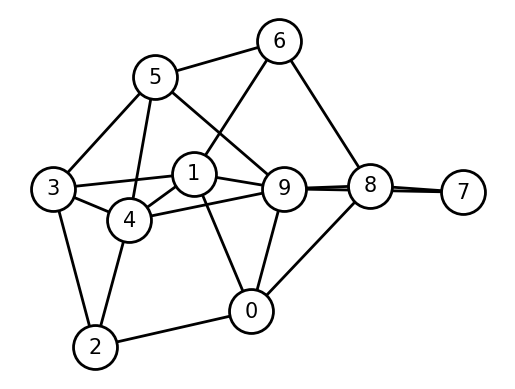

In [ ]:
subax1 = plt.subplot(111)
options = {
    "font_size": 15,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 2,
    "width": 2,
}
nx.draw(G, with_labels=True,**options)


### 2.1. EDMD for local approximation

In [ ]:
# -*- coding: utf-8 -*-
from sympy.polys.orderings import monomial_key
from sympy.polys.monomials import itermonomials
from numpy.linalg import inv, eig, pinv, det
from scipy.linalg import svd, svdvals, sqrtm
from numpy import diag, dot, real, imag
from IPython import display

# Sample data within epsilon nbhd
def sample_data(dic,N,T, eps):
    X = np.empty((T*N,n))
    Y = np.empty((T*N,n))
    P = 2*np.random.rand(N,n)-1;
    P =  P/np.linalg.norm(P,axis=1).reshape(N,1); P = eps*P*np.random.rand(N,1)
    Start = P
    for k in range(T):
        X[k*N:(k+1)*N,:] = P
        P = P + dt*np.array(f(*P.T)).T
        Y[k*N:(k+1)*N,:] = P
    X = basis_fun(X.T)
    Y = basis_fun(Y.T)
    return X,Y, Start

# Dictionary of monomials for EDMD, deg = 3 i.e. 286-1 total dictionary functions
def basis_fun(X):
    ret = np.ones((len(monomials),X.shape[1]))
    ret[1:,:] = np.array(basis(*X)[1:])
    return ret[1:,:]

deg = 3
monomials = sorted(itermonomials(x, deg), key=monomial_key('grlex', x))
basis = sp.lambdify(x,monomials,"numpy")

# EDMD
N = 100; T=1000; eps = 0.05; dt=0.01
X,Y,Start = sample_data(basis_fun,N,T,eps=eps)

Fphi = np.eye(X.shape[0])
Xtr = X.copy()
Ytr = Y.copy()

A = np.matmul(Ytr,np.linalg.pinv(Xtr))
mu,phi = eig(A.T)
lam = np.log(mu)/dt
K = np.diag(mu)
phi = np.matmul(Fphi,phi)
res_eig = np.abs(np.matmul(phi.T,Y) - np.matmul(K.T,np.matmul(phi.T,X)))
res_eig = np.max(res_eig,axis=1)
#print(np.sort(res_eig))

# Get the stable eigenmodes
stable = np.argwhere(real(lam)<0).T[0]
phi_stable = phi[:,stable]
lam_stable = lam[stable]
sort_idx = np.argsort(real(lam_stable))
phi_stable = phi_stable[:,sort_idx]
lam_stable = lam_stable[sort_idx]

# Sparsify the polynomial coefficients
g = sp.Matrix(real(phi_stable.T)*(abs(real(phi_stable.T))>1e-3))*sp.Matrix(monomials[1:])

In [ ]:
print((lam_stable))
print(np.sort(real(E)))

In [ ]:
#Define the eigenfunction PDE

from nangs import PDE

eig_idx = -1
l1 = real(lam_stable[eig_idx]); g1 = sp.lambdify(x,g[eig_idx]) #Change the index -1 to learn a different principle eigenfunction
H = lambda t,X : torch.vstack(f(*tuple(X[0:-1])) + (((1/(t+1e-5))*(-X[-1] + np.exp(-l1*t)*g1(*tuple(X[0:-1])))),))
eps=1.; 0.45;
class Eigen(PDE):
    def computePDELoss(self, inputs, outputs):

        # compute gradients
        grads = self.computeGrads(outputs, inputs)

        # compute loss
        x = tuple([inputs[:, i].cpu().detach() for i in range(n)])
        p = outputs
        u = f(*x)
        pde = -l1*p
        for i in range(n):
          pde = pde + u[i].to(device)*grads[:,i]
        return {'pde': 0.01*pde}

# instantiate pde
pde = Eigen(inputs=tuple([str(x_) for x_ in x]), outputs='p')

# define the sampler
from nangs import RandomSampler
box={}
for i in range(n):
  box[str(x[i])]=[-eps, eps]
sampler = RandomSampler(box, device=device, n_samples=2000)
pde.set_sampler(sampler)

### 2.2. Prepare training data using GLA

In [ ]:
samples_per_face = 100
T = 50.
X_box = torch.empty(0)
Y_box = torch.empty(0)
for i in range(n):
  #Face A
  dic=box #This is apparently not a deep copy, caution!
  dic[str(x[i])]=[eps,eps]
  X_ = tuple(torch.rand(samples_per_face,)*(lims[1] - lims[0]) + lims[0] for var, lims in dic.items())
  Y_ = odeint(H, torch.vstack(X_ + (torch.zeros(samples_per_face),)), torch.tensor([0.,T]))[-1][-1]
  Y_box = torch.hstack((Y_box,Y_))
  X_box = torch.hstack((X_box, torch.vstack(X_)))
  #Face B
  dic=box
  dic[str(x[i])]=[-eps,-eps]
  X_ = tuple(torch.rand(samples_per_face,)*(lims[1] - lims[0]) + lims[0] for var, lims in dic.items())
  Y_ = odeint(H, torch.vstack(X_ + (torch.zeros(samples_per_face),)), torch.tensor([0.,T]))[-1][-1]
  Y_box = torch.hstack((Y_box,Y_))
  X_box = torch.hstack((X_box, torch.vstack(X_)))
  dic[str(x[i])]=[-eps,eps]

#Interior
samples_interior = 1000
X_ = tuple(torch.rand(samples_interior,)*(lims[1] - lims[0]) + lims[0] for var, lims in dic.items())
Y_ = odeint(H, torch.vstack(X_ + (torch.zeros(samples_interior),)), torch.tensor([0.,T]))[-1][-1]
Y_box = torch.hstack((Y_box,Y_))
X_box = torch.hstack((X_box, torch.vstack(X_)))

In [ ]:
class Dirichlet(nangs.bocos.boco.Boco):
    def __init__(self, X_box, Y_box, name="dirichlet"):
        super().__init__(name)
        self.X_ = X_box.T
        self.Y_ = Y_box

    def validate(self, inputs, outputs):
        super().validate()

    def computeLoss(self, model, criterion, inputs, outputs):
        y_hat = model(self.X_)[:,0]
        y = self.Y_
        return {self.name: criterion(y, y_hat)}

initial_condition = Dirichlet(X_box.to(device),Y_box.to(device),"faces")
pde.add_boco(initial_condition)

### 2.3. Train

In [ ]:
# solve
from nangs import MLP

LR = 1e-2
N_STEPS = 2000
NUM_LAYERS = 3
NUM_HIDDEN = 128

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, div_factor=10, final_div_factor=1, total_steps=N_STEPS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(N_STEPS)

In [ ]:
# plot loss history
import pandas as pd

df = pd.DataFrame(hist)
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
ax.set_yscale('log')
df.plot(ax=ax, grid=True)

In [ ]:
# Save stuff as needed to computer

import pickle
from google.colab import files

# Save dynamics
with open('a.pickle', 'wb') as outf:
    pickle.dump(a, outf)
files.download('a.pickle')

# Save learnt DNN eigenfunction corresponding to eigenvalue l1
torch.save(mlp.state_dict(),'checkpoint_GLA_' + str(round(l1,2)) + '.pth')
files.download('checkpoint_GLA_' + str(round(l1,2)) + '.pth')

### 2.4. Evaluate

In [ ]:
m=200
T=10
X = tuple(torch.rand(m,)*(lims[1] - lims[0]) + lims[0] for var, lims in box.items())
X_traj = odeint(H, torch.vstack(X + (torch.zeros(m),)), torch.tensor(np.linspace(0,T,10*T)))

In [ ]:
p = pde.eval(X_traj.to(device).permute(0,2,1)[:,:,0:n])
p = p.cpu().numpy()[:,:,0]
plt.plot(p[0:100,:]**2); # Lyapunov basis functions

### Please note:
Corresponding to other $\lambda_i$ in spectrum of A, compute other DNN-based principal eigenfuctions by re-running everything starting with [this EDMD code cell](https://colab.research.google.com/drive/1_asH22FD43Nr_fEbHKKSw_EYJ4zfzzCf#scrollTo=b9blGcLpXmYA&line=3&uniqifier=1) onwards (please change $l_1$ and $g_1$ accordingly in the first line of the cell: l1 = real(lam_stable[***new_index***]); g1 = sp.lambdify(x,g[***new_index***])). Save each of these with the help of [this cell.](https://colab.research.google.com/drive/1_asH22FD43Nr_fEbHKKSw_EYJ4zfzzCf#scrollTo=LTbUVEuyogT-&line=6&uniqifier=1)

### 2.5. Load pretrained models (each model corresponds to one particular eigenfunction)

In [ ]:
%%capture
!pip install torchdiffeq
!pip install nangs
!pip install -U kaleido

In [ ]:
from nangs import MLP
from google.colab import files

import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from torchdiffeq import odeint
import nangs
import math
import pickle

device = "cuda" if torch.cuda.is_available() else "cpu"
nangs.__version__, torch.__version__

#Uncomment 2 lines below to upload saved items from computer to collab
#files.upload(); # trained DNN params
#files.upload(); # dynamics

!wget -i https://github.com/dekovski/GLA_Neural_Lyapunov/raw/main/saved/list.txt

In [ ]:
import glob

dir_path = r'/content/*.pth*'
res = glob.glob(dir_path)

In [ ]:
NUM_LAYERS = 3
NUM_HIDDEN = 128

mlp_list = []
for i,name in enumerate(res):
  state_dict = torch.load(name)
  mlp = MLP(10,1, NUM_LAYERS, NUM_HIDDEN).to(device)
  mlp.load_state_dict(state_dict)
  mlp_list = mlp_list + [mlp]

V_basis = lambda X : torch.concat([mlp(X) for mlp in mlp_list],axis=2)

with open('/content/a_param.pickle', 'rb') as inf:
   a = pickle.loads(inf.read())

n = 10 # number of agents
x = sp.symbols('x1:'+str(n+1), real=True)

b = sp.Matrix([1/(1+sp.exp(-x_)) for x_ in x])
f = sp.matrices.dense.matrix_multiply_elementwise(b,a)
f[0] = f[0] - 0.01*x[0]
A = f.jacobian(x).subs([(x_,0) for x_ in x])
E,W = np.linalg.eig(np.array(A.T).astype(np.float64))

f = f - (0.1 - min(E))*sp.Matrix(x)
f = 0.1*f
A = f.jacobian(x).subs([(x_,0) for x_ in x])
E,W = np.linalg.eig(np.array(A.T).astype(np.float64))

f = sp.lambdify(x,tuple(f))
F = lambda t,X : torch.vstack(f(*X))

In [ ]:
from torchdiffeq import odeint
box={}
eps = 1.5
for i in range(n):
  box[str(x[i])]=[-eps, eps]

m=500
T=100

X = tuple(torch.rand(m,)*(lims[1] - lims[0]) + lims[0] for var, lims in box.items())
X_traj = odeint(F, torch.vstack(X), torch.tensor(np.linspace(0,T,10*T)))
Y = V_basis(X_traj.permute(0,2,1)).detach().numpy()

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px

df = pd.DataFrame(Y[:,:,0])
#fig = px.line(df,line_color='red')
fig = go.Figure()
# Create and style traces
x = np.linspace(0,T,10*T)
coeff = np.random.rand(Y.shape[2]);
coeff = np.round(coeff/np.sum(coeff),2)
np.dot(Y,coeff)
for i in range(m):
  #y = Y[:,i,0]
  y = np.dot(0.5*Y**2,coeff)[:,i]
  #fig.add_trace(go.Scatter(x=x[0:100],y=y[0:100], showlegend=False,line=dict(color="rgba( 143, 82, 244,0.2)", width=2)))
  fig.add_trace(go.Scatter(x=x[0:100],y=y[0:100], showlegend=False,line=dict(color="rgba(220,20,60, 0.2)", width=2)))

#fig.update_layout(xaxis_title='t',yaxis_title='V<sub>i</sub>(x(t))')
fig.update_layout(xaxis_title='t',yaxis_title='V(x(t))')
fig.update_xaxes(title_standoff = 0, title_font_size=25, tickfont_size=25)
fig.update_yaxes(title_standoff = 0, title_font_size=25, tickfont_size=25)
#fig.update_layout(title_text='λ<sub>i</sub> = 0.69', title_x=0.5, title_pad=dict(b=0), title_font_size=25)
alpha = [c for c in coeff]
fig.update_layout(title_text='α = '+ str(alpha), title_x=0.5, title_pad=dict(b=0), title_font_size=25)
fig.update_layout(width=600, height=400, margin=dict(t=50,b=5,r=20,l=100))

# Show plot
fig.show()


In [ ]:
import plotly.io as pio
pio.write_image(fig, 'V.png', scale=4)